# Monte Carlo-simuleringer av polymerfolding

# Innledning

En polymer er en lang kjede bestående av repeterende enheter kalt monomerer. Biofysikk beskjeftiger seg med å simulere foldingen av ulike polymerer, og denne kunnskapen kan for eksempel bidra til å lage bedre materialer. For små systemer av polymerer brukes Newtons lover og løser systemet deterministisk. I vårt prosjekt, derimot, skal vi gjøre Monte Carlo-simuleringer, en stokastisk tilnærming som også brukes ofte til biofysisike simuleringer. Først implementerer vi grunnleggende polymerfunksjonalitet, som for eksempel hvordan vi skal representere polymeren numerisk og hvordan vi skal plotte og rotere den. Simuleringer er ofte tidkrevende og derfor diskuterer skal vi også diskutere kodeforbedringer vi gjorde for å redusere kjøretiden. Til slutt plotter vi simuleringer og drøfter resultatene. For eksempel skal vi simulere en krystalliseringsprosess, en prosess hvor polymerer folder seg sammen til en tett struktur.


In [1]:
#Importerer nødvendige bibliotek
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from scipy.stats import linregress
from scipy.spatial.distance import cdist as cdist
import timeit
from numba import jit
from matplotlib.colors import ListedColormap
import random

## Grunnleggende polymerfunksjonalitet

### Oppgave 1a og 1b
For å representere polymeren numerisk brukte vi to tilnærminger. Vi hadde en *absolutt beskrivelse* der vi representere hver monomer som en todimensjonal vektor, slik at polymeren ble en $(N, 2)$-array, der $N$ er antall monomerer i polymeren. Videre i prosjektet vil vi kalle denne representasjonen for $(N, 2)$. Oftest bruker vi en *relativ beskrivelse* som er et array med lengde $N-1$, der tallene $-1$, $0$ eller $1$ angir relativ vridning fra den forrige monomeren til henholdsvis venstre, rett frem og høyre (merk at første monomer ikke er med siden elementene er relativ vridning fra den forrige). Videre kommer vi til å kalle denne representasjonen for $(N-1)$. For å illustrere den relative modellen bedre er polymeren som blir rotert fire ganger i oppgave 1g representert med følgende array: $(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1)$.

Årsaken til at vi utviklet disse to tilnærmingene var fordi de begge hadde sine fordeler. $(N-1)$-representasjonen var mye raskere til å rotere polymeren da dette innebærte kun å endre et tall. Selv ved kløktig bruk av numpy-funksjonaliter var den relative modellen mye raskere til å rotere en polymer. Imidlertid var *(N, 2)* mye kjappere til å beregne energien og diameteren til polymeren siden vi kunne bruke lineær algebra-funksjoner fra Numpy og Scipy. Vi endte derfor opp med en hybridløsning. For rotasjon brukte vi *(N-1)*-representasjonen, mens der det var tidsbesparende å transformere og bruke lineær algebra brukte vi $(N, 2)$-representasjonen.

In [2]:
#Tar inn antall monomerer N på polymeren og returnerer en horisontal polymer i (N-1)-representasjon
def poly_init(N):
    return np.zeros(N-1)


#Tar inn en polymer i (N-1)-representasjon og returnerer dens (N, 2)-representasjon
@jit(nopython=True)
def rel_to_abs(poly):

    #Lager tom matrise med dimensjon (N, 2)
    N = len(poly) +1
    resultat = np.zeros((N, 2))

    #Setter startposisjon som (0, 0) og definerer retning
    pos = np.array([0, 0])
    dir = 0

    #Setter første monomer i origo og lager en retningsmatrise
    resultat[0] = pos
    retningsmatrise = np.array([[1,0], [0, -1], [-1, 0], [0, 1]])

    #Setter inn posisjonene inn i matrisen
    for i in range(len(poly)):
        dir = int(dir+poly[i])%4
        mat = retningsmatrise[dir]
        pos = pos + mat #endrer posisjonen
        resultat[i+1] =  pos #setter verdien

    #Returnerer (N, 2)-representasjonen
    return resultat

### Oppgave 1d
Vi definerer så en funksjon for å kunne plotte polymeren. Vi lager først en funksjon *plot_matrix* for å kunne sette inn en $(N-1)$-polymer i et stort array. I denne funksjonen beskærer vi også kantene. *plot_matrix*-funksjonen blir så brukt av *plot*-funksjonen som tar inn $(N-1)$-polymeren og deretter lager et pcolormesh. Monomerene er farget og nummerert for å kunne skille dem fra hverandre og bakgrunnen.

In [3]:
#Tan inn (N-1)-polymer og plasserer den i en matrise for å kunne plottes
def plot_matrix(poly):

    #Lager en tom matrise av størrelse 2Nx2N
    N = len(poly) +1
    resultat = np.zeros((2*N, 2*N))

    #Velger startposisjon (N, N) og definerer retning
    pos = np.array([N, N])
    dir = np.array([1, 0])

    #for å zoome inn behøver man max og min av x og y posisjonene
    x_pos = [N]
    y_pos = [N]

    #Setter inn første monomer
    resultat[pos[0], pos[1]] = 1

    #Setter inn de resterende monomerene
    for i in range(len(poly)):
        if poly[i] == 0:
            mat = np.array([[1, 0],[0, 1]]) #rett frem
        elif poly[i] == 1:
            mat = np.array([[0, 1], [-1, 0]]) #høyre
        elif poly[i] == -1:
            mat = np.array([[0, -1], [1, 0]]) #venstre
        dir = np.matmul(mat, dir) #endrer retningen man peker i
        pos = pos + dir #endrer posisjonen


        #Setter inn verdien
        resultat[pos[0], pos[1]] = i+2 #setter verdien

        #Legger til x- og y-verdiene for å finne største og minste, slik at vi kan zoome inn
        x_pos.append(pos[0])
        y_pos.append(pos[1])

    #Zoomer inn
    resultat = resultat[np.min(x_pos)-1:np.max(x_pos)+2, np.min(y_pos)-1:np.max(y_pos)+2]
    return resultat

In [4]:
#Tar inn en (N-1)-polymer og lager et pcolormesh
def plot(poly):

    #Plasserer (N-1)-polymeren på en stor matrise og roterer den til riktig retning
    trans = plot_matrix(poly)
    matrise = np.transpose(trans)


    #Legger til bakgrunnsfargen og N ulike grønnfarger
    colors = ["lightgray"]
    scaling = 1
    for i in range(len(poly) + 1):
        colors.append((0, scaling, 0))
        scaling = scaling *0.95

    #Lager plots og velger colormap
    fig, ax = plt.subplots()
    cmap = ListedColormap(colors)


    #Plotter pcolormesh og setter inn tall for monomerene
    ax.pcolormesh(matrise[::1, ::1], cmap = cmap, edgecolors = "k", linewidth = 1/40)
    for i in range(matrise.shape[0]):
        for j in range(matrise.shape[1]):
            if matrise[i,j] != 0:
                plt.text((j + 0.5), (i + 0.5), int(matrise[i, j]), ha = "center", va = "center", fontsize = 10)

    #Gjør at lengdene og høydene til boksene i pcolormesh alltid er like store
    plt.gca().set_aspect('equal', adjustable = 'box')
    plt.show()

### Oppgave 1e
Deretter laget vi en funksjon for å sjekke om en polymer er intakt. For at polymeren skal være intakt, må den ha lengde $N$, og monomerene må kunne unikt representeres av et heltall fra $1$ til $N$. Dessuten må monomer nummer $m \in [1, N-1]$ må være nabo med monomer $m+1$. Siden ingen av funksjonene våre kunne endre lengden på polymeren, droppet vi å sjekke om dens lengde var $N$, og følgelig droppet vi også lengden som inputparameter. Monomerene er også unikt identifisert med $(N-1)$-representasjon, der monomer nummer 1 tilsvarer ingen indeks og deretter er monomer nummer $m$ indeks $m-2$ i $(N-1)$-representasjon. Med $(N-1)$-representasjon er vi også sikret at nabomonomerer alltid er ved siden av hverandre. Det gjenstår derfor bare å sjekke om monomeren ikke opptar samme plass. Siden vi senere skal forsøke å rotere og sjekke om rotasjonen er gyldig mange ganger, var det viktig å minimere kjøretiden til denne funksjonen. Derfor brukte vi Numbas JIT-kompilator, som egner seg for gjentagende beregninger. Merk at vi prøvde også transformere til $(N,2)$ og deretter bruke *np.unique* for å sjekke antall unike monomerer, men dette viste seg å være tregere.

In [5]:
@jit(nopython=True)
def gyldig_polymer_2(poly):

    #Lager en stor matrise hvor vi putter inn monomerene
    N = len(poly) +1
    resultat= np.zeros((2*N, 2*N))
    success = True

    #Setter startposisjon som midt på matrisen og definerer retning
    pos = np.array([N, N])
    dir = 0

    #Setter inn første monomer og definerer retningene
    resultat[pos[0], pos[1]] = 1
    retningsmatrise = np.array([[1,0], [0, -1], [-1, 0], [0, 1]])

    #Setter inn resterende monomerer
    for i in range(len(poly)):
        dir = int(dir+poly[i])%4
        mat = retningsmatrise[dir]
        pos = pos + mat

        #sjekker om plassen allerede er tatt og setter inn monomeren
        if resultat[pos[0], pos[1]] == 0:
            resultat[pos[0], pos[1]] = i+2

        else:
            #Bryter ut av løkken dersom plassen er tatt
            success = False
            break

    return success

### Oppgave 1c og 1f
Vi laget så en funksjon for å rotere polymeren, og her sparte vi mye tid med å bruke $(N-1)$-representasjonen. I funksjonen putter man inn polymeren i $(N-1)$, sammen med en koordinat det befinner seg en monomer. Hvis vi forsøker å rotere om et endepunkt, endres ikke den relative distansen mellom monomerene og følgelig ikke polymerens energi. Så derfor er det ikke poeng å putte inn endemonomeren som rotasjonspunkt. Med $(N-1)$ innebærer dette at vi putter inn $n \in [1, N-1]$. Da vil vi ikke rotere om et endepunkt (merk at indeks 1 tilsvarer andre monomer). Vi skulle også putte inn en boolsk variabel som skal si om rotasjonen er med eller mot klokka. Vi tar heller inn en retning *dir* som enten er -1 eller 1. Dette gjør beregningene raskere og dette kunne enkelt ha blitt gjort med en boolsk variabel for deretter å transformere til -1 eller 1, men dette ville vært tregere. Som nevnt i avsnittet over: Siden rotasjonsfunskjonen skal kjøres mange ganger, er det viktig å minimalisere kjøretiden. Merk at vi også prøvde å bruke JIT-kompilator på rotasjonsfunksjonen, men når vi testet, økte faktisk JIT-kompilatoren kjøretiden - selv når vi gjentok funksjonen millioner av ganger. Dette skyldes nok at beregningen i funksjonen er enkel, og derfor taper vi bare på at rotasjonsfunksjonen må kompilere først.

In [6]:
#Tar inn (N-1)-polymer og en indeks for en monomer og -1 eller 1 for retning. Returner rotert polymer
def rotasjon(poly, i, dir):
    resultat= poly.copy()
    resultat[i] = resultat[i] + dir #endrer retningen i element i, med dir
    return resultat

### Oppgave 1g
Implementerer algoritme 1 for tilfeldig rotasjon i henhold til beskrivelsen.

In [7]:
def tilfeldig_rotasjon(poly, N):
    suc_rot = 0 #vellykkede rotasjoner
    rotasjonsfeil = 0
    dir_arr = [-1, 1] #retningsarray, vrir enten til høyre eller til venstre
    norm = len(poly)
    resultat= poly.copy()
    for i in range(N):
        #velger tilfeldig monomer (ikke først eller siste)
        m = np.random.randint(1, norm)

        #velger tilfeldig retning
        dir_index = np.random.randint(0, 2)

        #Sjekke om polymeren forsøker å rotere over seg selv
        if resultat[m] + dir_arr[dir_index] <= 1 and resultat[m] + dir_arr[dir_index] >= -1:
            #roterer
            res_pot = rotasjon(resultat, m, dir_arr[dir_index]) #potensiell ny polymer
            success = gyldig_polymer_2(res_pot)

            #tester rotasjonen
            if success:
                resultat = res_pot

                #inkrementerer vellykkede rotasjoner
                suc_rot = suc_rot + 1

    return resultat, suc_rot

In [34]:
poly = poly_init(15)
poly, suc_rot4 = tilfeldig_rotasjon(poly, 4)
fname4 = "tilfeldig_rotasjon_4"
np.savez(fname4, poly, np.array([suc_rot]))

In [47]:
poly = poly_init(15)
poly, suc_rot1000 = tilfeldig_rotasjon(poly, 1000)
fname1000 = "tilfeldig_rotasjon_gyldige_1000"
np.savez(fname1000, poly, np.array([suc_rot]))

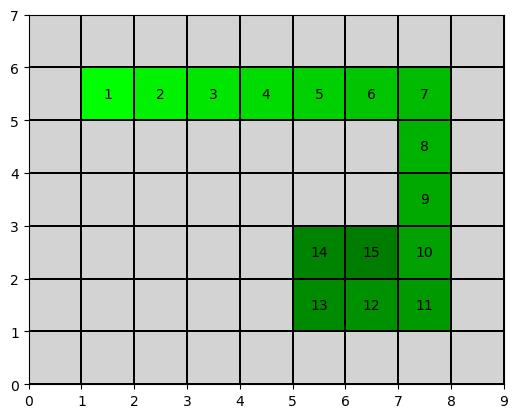

In [57]:

npzfile = np.load(fname4+".npz")
plot(npzfile['arr_0'])

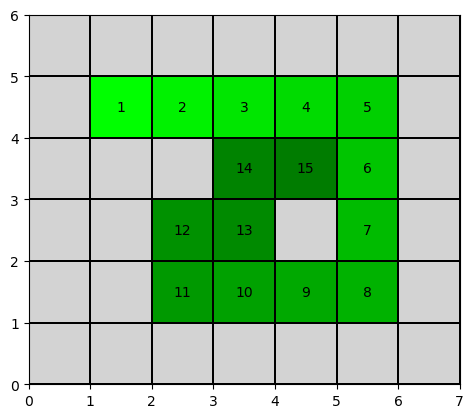

In [49]:
npzfile = np.load(fname1000+".npz")
plot(npzfile['arr_0'])


Polymeren blir er mer sammenkrøllet etter 1000 tilfeldige rotasjoner enn 4, som er som forventet siden 4 rotasjoner sannsynligvis ikke er nok til å krølle en polymer veldig mye, mens 1000 er det.

### Oppgave 1i
Vi skal prosentandelen gyldige rotasjoner som funksjon av polymerens lengde $N$. Vi plotter andelen gyldige rotasjoner for polymerer med lengde $N$ mellom 10 og 50 for både $100$, $1000$, $10000$ antall forsøkte rotasjoner.

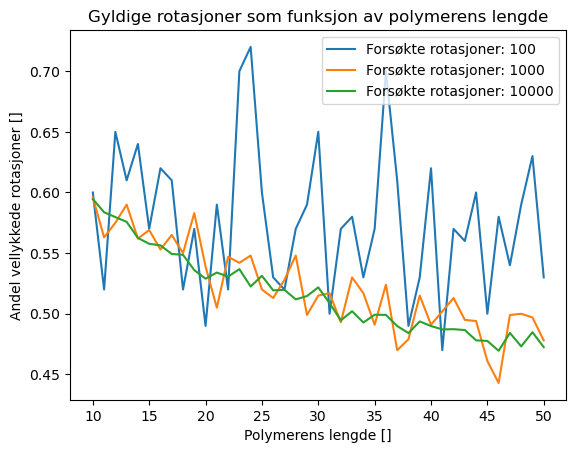

In [12]:
#Definerer variabler
N_f = [100, 1000, 10000]
N_arr = np.arange(10, 51, 1)
gyldige_rotasjoner_arr = [[], [], []]

#Plotter
fig, ax = plt.subplots()
for k in range(len(N_f)):
    for i in N_arr:
        poly = poly_init(i)
        poly, suc_rot = tilfeldig_rotasjon(poly, N_f[k])
        gyldige_rotasjoner_arr[k].append(suc_rot)
    ax.plot(N_arr, np.array(gyldige_rotasjoner_arr[k])/N_f[k], label="Forsøkte rotasjoner: "+str(N_f[k]))
ax.set_xlabel("Polymerens lengde []")
ax.set_ylabel("Andel vellykkede rotasjoner []")
ax.legend()
plt.title("Gyldige rotasjoner som funksjon av polymerens lengde")
plt.show()

Trenden er at andel vellykkede rotasjoner synker med økende lengde på polymeren, som er som forventet, siden en lengre polymer vil skape flere muligheter for at polymeren folder seg over seg selv, som ikke vil være en vellykket rotasjon. Videre virker andelen vellykkede rotasjoner å være høyere ved et lavere antall forsøkte rotasjoner, som også er som forventet, siden de første rotasjonene har høyere sannsynlighet for å være vellykkede. Samtidig er også variasjonen i andel vellykkede rotasjoner høyere for lavere antall forsøkte rotasjoner.

### Oppgave 1j
Vi implementerer så en funksjon for å beregne energien til polymeren. Energifunksjonen tar inn en *(N, 2)*-representasjon av en polymer og et symmetrisk potensial som inneholder vekselvirkningene mellom monomerene. I potensialet er diagonalen, under- og overdiagonalen lik 0. Inne i energifunksjonen definerer vi operatoren $B$ som er $1$ hvis monomer $m$ og $n$ er naboer og $0$ ellers. For å sjekke om to monomerer er naboer bruker vi scipys cdist-funksjon. Cdist tar inn den todimensjonale polymeren to ganger og lager en $N \times N$ matrise der element $a_{ij}$ er avstanden mellom monomer nummer $i$ og $j$. Deretter setter vi manuelt alle avstander over $1$ lik $0$.

In [13]:
#Tar inn polymer og et symmetrisk potensial og returnerer polymeres energi
def energy(polymer, V):

    #Lager et NxN array med avstandene
    B = cdist(polymer, polymer)

    #setter avstander over 1 lik 0
    B[B>1] = 0

    return 0.5 * np.sum(np.multiply(V, B))

Vi lager også en en funksjon for å returnerer en potensialmatrise der alle ikke-null elementene er $-1$. Diagonalen, under- og overdiagonalen er null i potensialmatrisene.

In [14]:
#Putter inn lengde på polymer og returnerer en enkel potensialmatrise
def krafmat(N):
    resultat = np.ones((N, N))*-1

    #itererer over arrayet for å sette 0
    for i in range(N):
        for j in range(N):
            if i == j or i == j +1 or i == j -1:
              resultat[i, j] = 0

    return resultat

Vi beregner så energien til polymerene i oppgave 1g

In [51]:
V = krafmat(15)
npzfile = np.load(fname4+".npz")
print("Energien etter 4 rotasjoner: ", energy(rel_to_abs(npzfile['arr_0']), V))

npzfile = np.load(fname1000+".npz")
print("Energien etter 4 rotasjoner: ",energy(rel_to_abs(npzfile['arr_0']), V))

Energien etter 4 rotasjoner:  -2.0
Energien etter 4 rotasjoner:  -4.0


Energien blir -2 for polymeren etter 4 rotasjoner og -4 for polymeren etter 1000 rotasjoner, som stemmer med at det er flere bindinger i polymeren etter 1000 enn 4 rotasjoner.

# Kodeforbedring

### Oppgave 1h
Det er forbedre kodehastigheten er interessant, slik at ventetiden blir lavere og størrelsen på simuleringen kan økes. I dette prosjektet er en operasjon som utføres hyppig rotasjon av polymeren, slik at det å forbedre rotasjonsfunksjonens hastighet vil kunne være effektivt. To forskjellige implementasjoner av rotasjon ble vurdert. Legg merke til at begge implementasjonene returnerer et polymer beskrevet på samme vis, altså formen *(N, 2)*. Rotasjonsfunksjonen implementert under var ett alternativ til den implementert tidligere i notatboken, men som, på grunn av kjøretid, ble valgt bort.

In [16]:
rot_matrix_cw = np.array(((0,1),(-1,0)))
rot_matrix_ccw = np.array(((0,-1),(1,0)))
#Implementasjonen av den første rotasjonsfunksjonen
def polymer_rotate(polymer, validcoordinate, isCCW):
    rotated_polymer = polymer
    index = np.where((polymer == validcoordinate).all(axis = 1))[0][0]

    polymer_to_rotate = polymer - validcoordinate
    if index + 1 >= polymer.shape[0]/2:
        polymer_to_rotate[:index:] = np.array((0,0))
        rotated_polymer[index::] = validcoordinate
    else:
        polymer_to_rotate[index::] = np.array((0,0))
        rotated_polymer[:index:] = validcoordinate

    if isCCW == True:
        rotated_rel_point = np.dot(polymer_to_rotate, rot_matrix_ccw)
    elif isCCW == False:
        rotated_rel_point = np.dot(polymer_to_rotate, rot_matrix_cw)

    rotated_polymer += rotated_rel_point

    return rotated_polymer

In [17]:
#Kjører 1_000_000 ganger istedet for 1_000 for å få mer nøyaktig resultat
antall_ganger = 1_000_000
#tester alternativ 1
N = 15
p = rel_to_abs(poly_init(N))
tid_1 = timeit.timeit(lambda: polymer_rotate(p, p[np.random.randint(1, N)], bool(random.getrandbits(1))), number=antall_ganger)

#tester alternativ 2
#legg merke til at man bruker funksjonen rel_to_abs for å få resultatet på (N, 2) form
p = poly_init(N)
tid_2 = timeit.timeit(lambda: rel_to_abs(rotasjon(p, np.random.randint(1, N-1), random.getrandbits(1)*2-1)), number=antall_ganger)

print("Alternativ nummer 1: ",tid_1, " s")
print("Alternativ nummer 2: ",tid_2, " s")
print("Forhold mellom nummer 1 og 2: ", tid_1/tid_2)

Alternativ nummer 1:  30.04632872700006  s
Alternativ nummer 2:  9.02100365299998  s
Forhold mellom nummer 1 og 2:  3.330707965849011


Man ser at alternativ 2 er omtrent 3 ganger raskere enn alternativ 1, og er dermed det åpenbare valget for å rotere. Alternativ 1 bruker *(N, 2)* for å rotere, mens alternativ 2 bruker *(N-1)*. Fordelen med *(N-1)* beskrivelsen, er at selve rotasjonen blir triviell, men ulempen er at det behøves en funksjon for å transformere fra *(N-1)* formen til *(N, 2)* formen, siden for eksempel energifunksjonen bruker *(N, 2)* form. Åpenbart er allikevel kombinasjonen av rotasjon på *(N-1)* form og transformasjon til *(N, 2)* form, mer effektiv enn direkte transformasjon på *(N, 2)* form, gitt benyttede implementasjoner. Dette skyldes altså sannsynligvis at selve rotasjonen blir enklere med *(N-1)* formen.



Vi skal nå se på hvordan kjøretiden skalerer med lengden på polymeren

Tilpasset linje alternativ 1: 0.00291 N + 1.51
Tilpasset linje alternativ 2: 0.00609 N + 0.373


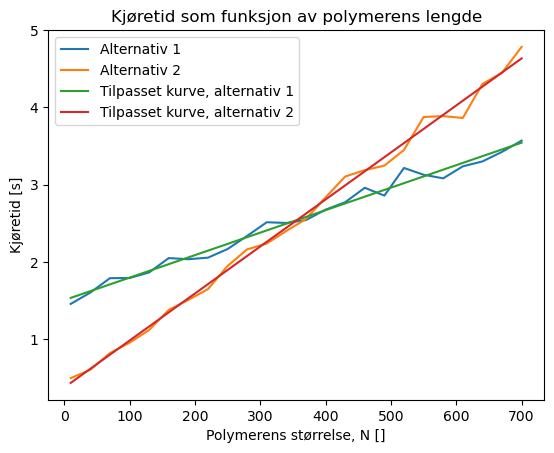

In [18]:
#Initialiserer nødvendige variable
N_arr = np.arange(10, 711, 30)
T_arr_1 = np.zeros(np.shape(N_arr))
T_arr_2 = np.zeros(np.shape(N_arr))
antall_ganger = 50_000
#Finner kjøretid for alternativ 1 og 2 for forskjellige N
for i in range(len(N_arr)):
  N = N_arr[i]
  p = poly_init(N)
  T_arr_2[i] = timeit.timeit(lambda: rel_to_abs(rotasjon(p, np.random.randint(1, N-1), random.getrandbits(1)*2-1)), number=antall_ganger)
  p = rel_to_abs(poly_init(N))
  T_arr_1[i] = timeit.timeit(lambda: polymer_rotate(p, p[np.random.randint(1, N)], bool(random.getrandbits(1))), number=antall_ganger)


#Utfører lineær regresjon
linregress_result_1 = linregress(N_arr, T_arr_1)
linregress_result_2 = linregress(N_arr, T_arr_2)

#Skriver ut resultatet og plotter
print(f"Tilpasset linje alternativ 1: {linregress_result_1[0]:.3g} N + {linregress_result_1[1]:.3g}")
print(f"Tilpasset linje alternativ 2: {linregress_result_2[0]:.3g} N + {linregress_result_2[1]:.3g}")
plt.plot(N_arr, T_arr_1, label="Alternativ 1")
plt.plot(N_arr, T_arr_2, label="Alternativ 2")
plt.plot(N_arr, linregress_result_1[0]*N_arr + linregress_result_1[1], label = "Tilpasset kurve, alternativ 1")
plt.plot(N_arr, linregress_result_2[0]*N_arr + linregress_result_2[1], label = "Tilpasset kurve, alternativ 2")
plt.xlabel("Polymerens størrelse, N []")
plt.ylabel("Kjøretid [s]")
plt.title("Kjøretid som funksjon av polymerens lengde")
plt.legend()
plt.show()

Kjøretiden virker å skalere relativt lineært som funksjon av polymerens størrelse, med omtrent 0.003 sekunder ekstra kjøretid per monomer for alternativ 1 og omtrent 0.006 sekunder ekstra kjøretid per monomer for alternativ 2, for 50 000 tilfeldige rotasjoner. Et interessant resultat er at alternativ 1 virker å skalere bedre med N enn alternativ 2, som kan skyldes at transformasjonen fra *(N - 1)* form til *(N, 2)* form skalerer dårligere enn alternativ 1, siden alternativ 1 i stor grad benytter numpy-funksjoner. Allikevel er alternativ 2 klart å foretrekke for våre verdier av *N*.

# Monte Carlo-simuleringer

## Oppgave 2a
Her implementeres metropolisalgoritmen i henhold til beskrivelsen.

In [28]:
#Tar inn polymer, antall Monte Carlo-steg, et potensial og temperatur. Returnerer polymeren og energiene
def metropolis(poly, N_s, V, T):
    E_array = np.zeros(N_s)
    E = energy(rel_to_abs(poly), V)
    i = -1
    dir_arr = [-1, 1] #retningsarray, vrir enten til høyre eller til venstre
    norm = len(poly)
    k_B = 1.38 * 10**(-23)
    beta = 1/(k_B*T)
    while i < N_s-1:

        #velger tilfeldig monomer
        m = np.random.randint(1, norm)

        #velger tilfeldig retning
        dir_index = np.random.randint(0, 2)

        #Sjekker om polymeren prøver å rotere over seg selv
        if poly[m] + dir_arr[dir_index] <= 1 and poly[m] + dir_arr[dir_index] >= -1:

            #roterer
            res_pot = rotasjon(poly, m, dir_arr[dir_index]) #potensiell ny polymer
            success = gyldig_polymer_2(res_pot)

            #tester rotasjonen
            if success:
                #inkrementerer vellykkede rotasjoner
                i = i + 1

                #beregner energien
                E_new = energy(rel_to_abs(res_pot), V)
                if E_new < E:
                    poly = res_pot
                    E = E_new
                elif np.random.uniform() < np.exp(-beta*(E_new-E)):
                    poly = res_pot
                    E = E_new
                E_array[i] = E
    return poly, E_array

### Oppgave 2b
Vi kjører nå to simuleringer der polymerens lengde er $35$, antall Monte Carlo-steg er 5000. I den ene simuleringer er temperaturen $75K$, og i den andre er temperaturen $350K$.

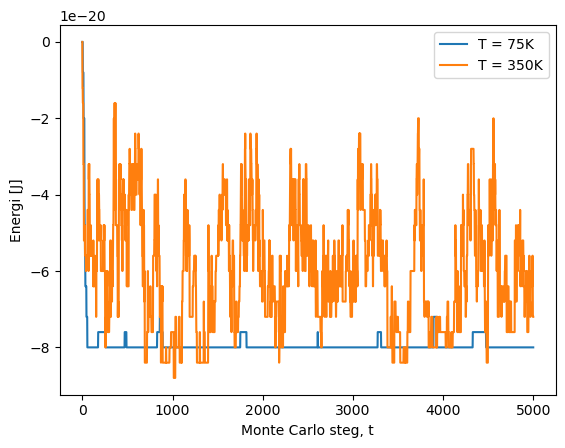

In [20]:
#Inititaliser konstanter
N_s = 5000
N = 35
V = krafmat(N)*4*10**(-21)

#Lar temperaturen være 75K
T = 75
poly_75 = poly_init(N)
poly_75, e_arr_75 = metropolis(poly_75, N_s, V, T)


#Lar temperaturen være 350K
T = 350
poly_350 = poly_init(N)
poly_350, e_arr_350 = metropolis(poly_350, N_s, V, T)

#Plotter energiene som funksjon av Monte Carlo steg
fig, ax = plt.subplots()
ax.plot(e_arr_75, label="T = 75K")
ax.plot(e_arr_350, label="T = 350K")
ax.set_xlabel("Monte Carlo steg, t")
ax.set_ylabel("Energi [J]")
ax.legend()
plt.show()

Energien varierer mye mer når temperaturen er 350K enn 75K, som ikke er overraskende, siden en høyere temperatur fører til en høyere sannsynlighet for at metropolis-algoritmen godtar en rotasjon som øker polymerens energi.

Når temperaturen er lav, vil det være usannsynlig at polymerens energi hopper ut av lokale (og det globale) energiminima, som gjør at om polymeren havner i et lokalt energiminimum, er det lite sannsynlig at den vil komme seg ut derifra. I figuren ser man også at polymerens energi endres veldig lite etter den initielle nedsenkningen, når temperaturen er 75K.

Når temperaturen er høy, er det mer sannsynlig at polymeren hopper ut av lokale (og det globale) energiminima, som fører til at polymeren vil ha flere forskjellige konfigurasjoner ved høy temperatur enn lav temperatur. Siden polymeren vil ha flere forskjellige konfigurasjoner ved høy enn lav temperatur, er det også mer sannsynlig at polymeren vil være i en konfigurasjon med lavere energi i løpet av simuleringen når temperaturen er høy enn når temperaturen er lav. Forventningen stemmer med figuren, hvor polymeren oppnår en lavere energitilstand når temperaturen er 350K enn 75K. Legg også merke til at polymeren hopper ut av denne laveste energitilstanden når temperaturen er 350K.


### Oppgave 2c
Vi plotter nå sluttposisjonene til polymerene fra forrige oppgave

T = 75K


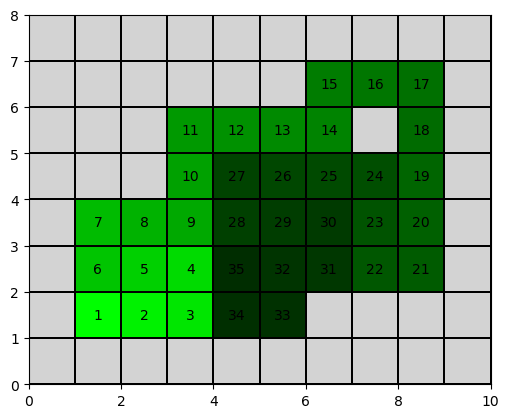

T = 350K


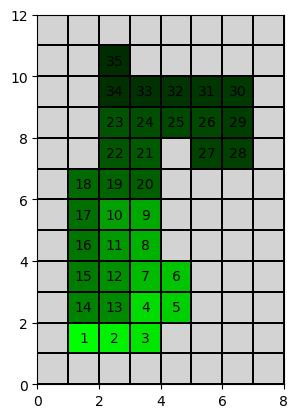

In [21]:
print("T = 75K")
plot(poly_75)
print("T = 350K")
plot(poly_350)

Her ser man at polymeren er mer kompakt når temperaturen er 75K enn 350K, som er forventet, siden sluttenergien er høyere for polymeren når temperaturen er 350K. En mer kompakt polymer vil føre til mindre omkrets og dermed lavere energi, og omvendt.

### Oppgave 2d
Vi lager nå et egendefinert potensial $V$ der alle ikke-null elementene er positive bortsett elementene $a_{1, N}$ og $a_{N, 1}$ negative med stor absoluttverdi. Vi forventer at alle monomerene bortsett fra første og siste vil frastøte hverandre og derfor ikke sammenkobles. Vi forventer også at første og siste monomer kobles sammen da tiltrekningen mellom disse er stor. Med andre ord forventer vi å få en monomer som er koblet i en ring.

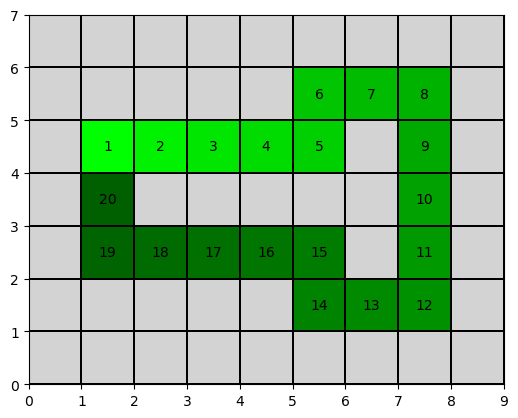

In [29]:
#initaliserer konstanter
N_s = 50000
N = 20
#Endrer fortegn på kraftmatrisen V, slik at det er lite sannsynlig at polymeren folder seg
V = krafmat(N)*4*10**(-21)*-1

#Modifiserer kraftmatrisen V
#Lar energien i bindingen mellom første og siste monomer bli veldig lav
V[0, N-1] = -4*10**(19)
V[N-1, 0] = V[0, N-1]

#Setter temperaturen til 75K
T = 75

#Initialiserer polymeren
poly = poly_init(N)

#Utfører metropolis N_s ganger
poly, e_arr = metropolis(poly, N_s, V, T)

#Plotter resultatpolymeretS
plot(poly)

Som forventet danner polymeren en ring, siden alle monomerene utenom den første og siste vil frastøte hverandre.

### Oppgave 2e

Videre skal vi estimere $\langle E ⟩$ og $σ_e$ som funksjon av $T$ i intervallet $[10K, 1000K]$ med temperatursteg på $30K$. For å få energiverdier som er representativt for tilstanden til polymeren vår, inkluderer vi ikke de første 1000 simuleringene. Vi skal også se om valget av antall Monte Carlo-steg $N_s$ påvirker gjennomsnittet og standardavvikket. Vi plotter derfor to grafer. Den ene regner gjennomsnittet og standardavviket ved å bruke $N_s = 1500$, det vil si at vi tar med 500 målinger etter de første 1000 eksluderte. Det andre plottet bruker vi $N_s = 5000$ og sammenligner med plottet for $N_s = 1500$ for å se om det er hensiktsmessig å ta med flere målinger for å estimere $\langle E ⟩$ og $σ_e$.

Text(0.5, 1.0, 'Energi som funksjon av temperatur i polymeren')

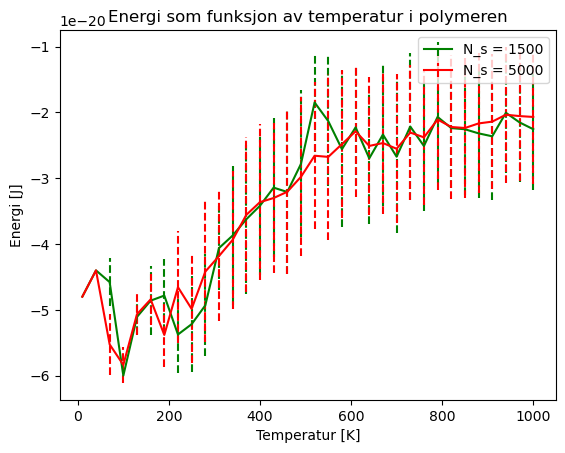

In [23]:
#Lager en horisontal polymer av lengde 25
N = 25
horizontal_polymer = poly_init(25)

#Lager et symmetrisk potensial
V = np.ones((N, N)) * (-4.0 * 10**(-21))
np.fill_diagonal(V[:, 1:], 0)
np.fill_diagonal(V[1:, :], 0)
np.fill_diagonal(V[:,:], 0)


#Lager aktuelle arrayer
T_vals = np.arange(10, 1_000+30, 30)
E_avg_array_1500 = np.zeros(len(T_vals))
E_sigma_array_1500 = np.zeros(len(T_vals))
E_avg_array_5000 = np.zeros(len(T_vals))
E_sigma_array_5000 = np.zeros(len(T_vals))

#Regner ut gjennomsnittsenergien og standardardavvikket som funksjon av temperatur
for i, T in enumerate(T_vals):
    p, E = metropolis(horizontal_polymer, 5000, V, T)
    #Legger til gjennomsnittet og std til N_s = 1500
    E_avg_array_1500[i] = np.average(E[1000:1500:])
    E_sigma_array_1500[i] = np.std(E[1000:1500:])

    #Legger til gjennomsnittet og std til N_s = 2000
    E_avg_array_5000[i] = np.average(E[1000::])
    E_sigma_array_5000[i] = np.std(E[1000::])

#plotter funksjonene
plt.errorbar(T_vals, E_avg_array_1500, yerr = E_sigma_array_1500, label = "N_s = 1500", fmt = "green", ls = '-')[-1][0].set_linestyle("dashed")
plt.errorbar(T_vals, E_avg_array_5000, yerr = E_sigma_array_5000, label = "N_s = 5000", fmt = "red", ls = '-')[-1][0].set_linestyle("dashed")
plt.xlabel("Temperatur [K]")
plt.ylabel("Energi [J]")
plt.legend()
plt.title("Energi som funksjon av temperatur i polymeren")

Fra plottet ser vi at $\langle E \rangle$ øker som funksjon av $T$, spesielt etter at temperaturen har nådd om lag $200K$. Årsaken til hvorfor energien er øyensynlig vilkårlig for lave temperaturer skyldes nok at polymerene innretter seg kjapt i energiminima hvor de aldri kommer seg ut av. Det er derfor hensiktsmessig å plotte flere  grafer ved samme temperatur, slik som vi gjør i neste plot. Hva angår  $\sigma_E$, øker den litt for høyere temperaturer. For høyere temperaturer er det større sannsynlig for å komme seg ut av lokale energiminimum og derfor er det rimelig at energien fluktuerer mer. Om vi hadde økt temperaturer, hadde vi nok sett større fluktuasjoner.

Vi ser også at plottet for energien med antall Monte Carlo-steg lik 5000 gir omtrent samme resultat som plottet med antall Monte Carlo-steg lik 1500. Det indikerer at energien har stabilisert seg etter de 1000 første eksluderte Monte Carlo-stegene og derfor vil ikke valget av $N_s$ temperaturavhengigheten gitt $N_s > 1500$. Av hensyn til kjøretid er det derfor hensiktsmessig å ikke velge $N_s$ for stor.

### Oppgave 2f
Vi vil nå velge en lavere temperatur fra forrige simuleringer og sjekke energien som funksjon av Monte Carlo-steg og ser om det gir et bedre anslag på energien ved lav temperatur. Vi velger å se på temperaturen 70K og gjøre 10 simuleringer.

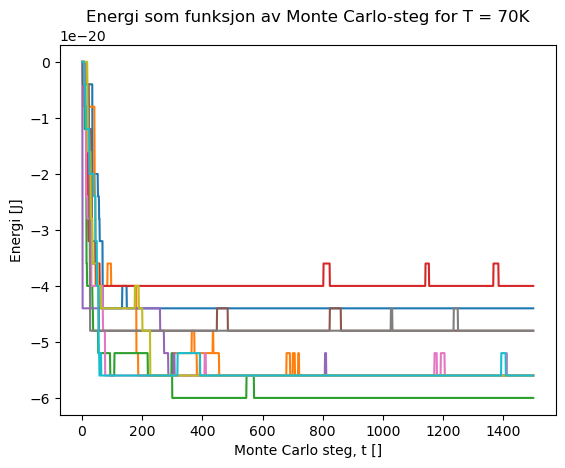

In [24]:
#Lager en horisontal polymer av lengde 25
N = 25
horizontal_polymer = poly_init(25)

#Setter temperaturen
T = 70

#Lager et symmetrisk potensial
V = np.ones((N, N)) * (-4.0 * 10**(-21))
np.fill_diagonal(V[:, 1:], 0)
np.fill_diagonal(V[1:, :], 0)
np.fill_diagonal(V[:,:], 0)


#Lager array med energiverdier
E_t_array = np.zeros((1500, 10))

#Kjører 1500 simuleringer
x = np.arange(1, 1500+1, 1)
for i in range(10):
  p, E = metropolis(horizontal_polymer, 1500, V, T)
  E_t_array[:, i] = E
  plt.plot(x,E_t_array[:, i])

plt.title("Energi som funksjon av Monte Carlo-steg for T = 70K")
plt.xlabel("Monte Carlo steg, t []")
plt.ylabel("Energi [J]")
plt.show()

Fra de $10$ simuleringene ser i at ved $70K$ vil polymeren fort gå inn i et energiminima for deretter aldri å kommme ut. Å plotte energien som funksjon av Monte Carlo-steg gir et bedre anslag på energien ved lave temperaturer enn forrige graf fordi ved lave temperaturer forventer vi at polymeren vil havne i en tilstand som er et lokalt energiminimum. Ved lave temperaturer er sannsynligheten for å havne i energetisk ugunstige tilstander lav, og dermed vil polymeren ha lite sannsynlighet for å komme ut av dette minimaet. Dette viser grafen over tydelig, men er ikke enkelt å se fra grafen der vi plotter energi som funksjon av temperatur. I tillegg har vi kun en simulering over polymeren ved $70K$. Vi kan derfor forvente at polymeren i forrige oppgave havnet i et minimum som ikke er representativt for den faktiske gjennomsnittlige energien til en polymer ved denne temperaturen. Ved høye temperaturer fluktuerer energien mye som funksjon av Monte Carlo-steg fordi det er stor sannsynlighet for å komme i energetisk ugunstige tilstander. Da gir nok grafen av energi som funksjon av temperatur et godt bilde den gjennomsnittlige energien og usikkerheten.

### Oppgave 2g og 2h
Til slutt skal vi måle diameteren $d$ av polymeren. Vi skal bruke et symmetrisk potensial der de ikke-null matriseelementene er i intervallet $[−6 \cdot 10^{−21}J,−2 \cdot 10^{−21}J]$. For å estimere $d$ tar vi gjennomsnittet av de målte $d$-verdiene. Vi tar bort de første 1000 målte diameterne av de totalt 20000 målte diameterne slik at de diameterne vi måler forhåpentligvis er representativ for polymerens faktiske diameter i det aktuelle potensialet. Vi lager en distansefunksjon og implementerer denne inn i Metropolis-algoritmen.

Vi lager to plot. I det første plottet skal vi øke øke temperaturen fra 10K til 1000K i steg på 30K og se hvordan diameterne blir for de ulike temperaturene. I dette plottet skal vi alltid begynne hver nye måling med en horisontal polymer. I det andre plottet skal vi derimot synke temperaturen med samme temperatursteg, men i dette plottet skal vi ikke tilbakestille polymeren. Dette vil forhåpentligvis fremstille krystallisasjon. Merk også at i plottene lar vi $u$ være distansen mellom to nabomonomerer. Denne distansen $u$ vil variere fra ulike polymerer.

In [53]:
#Lager en distansefunksjon som tar inn (N, 2)-polymer og returnerer den største avstanden mellom to monomerer i polymeren
def distance(polymer):
  distance_matrix = cdist(polymer, polymer)
  return np.max(distance_matrix)


#Oppdaterer Metropolis-algoritmen. All kode bortsett fra den kommenterte er identisk med den forrige. Returnerer nå også diameteren
def metropolis(poly, N_s, V, T):
    E_array = np.zeros(N_s)
    E = energy(rel_to_abs(poly), V)
    i = -1
    dir_arr = [-1, 1]
    norm = len(poly)
    k_B = 1.38 * 10**(-23)
    beta = 1/(k_B*T)
    D_array = np.zeros(N_s) #Lager et distanse-array
    while i < N_s-1:
        m = np.random.randint(1, norm)
        dir_index = np.random.randint(0, 2)
        if poly[m] + dir_arr[dir_index] <= 1 and poly[m] + dir_arr[dir_index] >= -1:
            res_pot = rotasjon(poly, m, dir_arr[dir_index])
            success = gyldig_polymer_2(res_pot)
            if success:
                i = i + 1
                P_abs = rel_to_abs(res_pot) #Transformerer polymeren til (N, 2)
                E_new = energy(P_abs, V) #Regner energien vha P_abs
                if E_new < E:
                    poly = res_pot
                    E = E_new
                elif np.random.uniform() < np.exp(-beta*(E_new-E)):
                    poly = res_pot
                    E = E_new
                E_array[i] = E
                D_array[i] = distance(P_abs) #Legger til distanse i D_array
    return poly, E_array, D_array #Returnerer nå også D_array

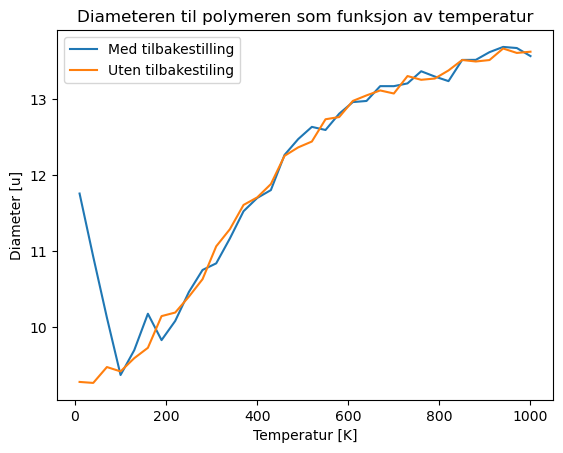

Tidsbruk for beregning med økende temperatur og tilbakestilling 100.80876950399988
Tidsbruk for beregning med synkende temperatur, men uten tilbakestilling 95.33887199799983


In [55]:
#Temperaturverdiene
T_array_increasing = np.arange(10, 1_000+30, 30)
T_array_decreasing = np.arange(1_000, 0, -30)

#d-arrayene
d_avg_increasing = np.zeros(len(T_array_increasing))
d_avg_decreasing = np.zeros(len(T_array_decreasing))


#Lager en horisontal polymer av lengde 35
N = 35
horizontal_polymer = poly_init(N)

#Lager tilfelidg symmetrisk matrise
V = np.random.uniform(low = -6*10**(-21), high = -2*10**(-21), size = (N, N))
np.fill_diagonal(V[:, 1:], 0)
np.fill_diagonal(V[:, :], 0)
np.fill_diagonal(V[1:, :], 0)
V_sym = (V + V.T)/2

#Finner d-verdiene for økende temperatur (med tilbakestilling)
tid1 = tm.perf_counter()
for i, T in enumerate(T_array_increasing):
  p, E, D = metropolis(horizontal_polymer, 20000, V_sym, T)
  d_avg_increasing[i] = np.average(D[999::])
tid2 = tm.perf_counter()

#tilbakestiller polymeren til horisontal
p = poly_init(N)

#Finner d-verdiene for synkende temperatur (uten tilbakestilling)
tid3 = tm.perf_counter()
for i, T in enumerate(T_array_decreasing):
  p, E, D = metropolis(p, 20000, V_sym, T)
  d_avg_decreasing[i] = np.average(D[999::])
tid4 = tm.perf_counter()

#Plotter funksjonene
fig, ax = plt.subplots()
ax.plot(T_array_increasing, d_avg_increasing, label = "Med tilbakestilling")
ax.plot(T_array_decreasing, d_avg_decreasing, label = "Uten tilbakestiling")
ax.legend()
ax.set_xlabel("Temperatur [K]")
ax.set_ylabel("Diameter [u]")
ax.set_title("Diameteren til polymeren som funksjon av temperatur")
plt.show()


print(f"Tidsbruk for beregning med økende temperatur og tilbakestilling {tid2-tid1}")
print(f"Tidsbruk for beregning med synkende temperatur, men uten tilbakestilling {tid4-tid3}")

Fra plottet ser vi at diameteren til polymeren øker med økende temperatur. Dette er ikke uventet siden polymeren har lavere energi hvis den er krummet slik at to monomerer som i utgangspunktet ikke er naboer, blir naboer. Altså vil et lokalt energiminima som regel tilsvare en lavere diameter. Med høyere temperatur kan polymeren enklere komme ut av disse energiminimaene og derfor også ha høyere diameter og energi. Begge måleseriene egner seg derfor like godt itl å beskrive polymerens høytemperaturoppførsel.

Ved lave temperaturer, derimot, er det en forskjell mellom målingene av diameteren til polymeren. I den ene måleserien der vi lar temperaturen synke gradvis uten å tilbakestille posisjon til polymeren, vil polymeren krystalliseres og antagelig innrette seg i et ganske lavt energinivå, noe vi ser fra plottet. Når vi måler diameteren til polymer der vi tilbakestiller polymeren til en horisontal polymer, vil den fort innrette seg i et lokalt minima, og dermed vil det også være stor variasjon i hva diameteren blir. For lave temperaturer og for å beskrive krystallisering er det derfor bedre å bruke metoden der man gradvis reduserer temperaturen uten å tilbakestille polymeren.


# Konklusjon
I prosjektet vårt fant vi at polymerer gjennomsnittsenergi, usikkerhet og diameter økte med temperaturen. For lavere temperaturer vil ofte polymeren havne i et lokalt energiminimum, mens for høyere temperaturer vil energien fluktuere mer. For lavere temperaturen krever det flere simuleringer for å finne gjennomsnittsverdiene for energien og diameteren. Vi har også funnet at en gradvis nedkjøing av en polymer tilsvare en krystalliseringsprosess.

Vi fant at en polymerrepresentasjon hvor vi beskrev de relativ vridningene mellom monomerene var mer effektivt for å rotere polymeren. Vi fant også at kjøretiden skalerer lineært med lengden på polymeren.